# **Reinforcement learning : Puissance 4**

Le but de ce script est d'implémenter un agent capable de jouer au jeu Puissance 4

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Création de l'environnement

In [57]:
NB_ROWS = 6
NB_COLUMNS = 7

In [58]:
class Game:
    """
    Class that describes a game being played
    """
    def __init__(self, nb_rows=6, nb_columns=7, nb_players=2):
        self.nb_rows = nb_rows
        self.nb_columns = nb_columns
        self.nb_players = nb_players
        self.grid = np.zeros((nb_rows, nb_columns))
        self.turn = 0
        self.nb_steps = 0 # Total number of steps in the game
        
    def is_draw(self):
        return self.nb_steps == self.nb_rows*self.nb_columns
        
    def is_legal(self, column):
        # Takes as input a column and return whether it is possible or not to put a token or the column (True or False)
        col_values = self.grid[:, column]
        non_zeros, = np.where(col_values == 0)
        return not (len(non_zeros) == 0)
    
    def set_token(self, column):
        # Takes as input a column, and in the move is legal, put a token in the column
        try:
            assert self.is_legal(column)
        except:
            raise Exception("The move is not legal. Column {} is already filled".format(column))
        
        row_index = np.where(self.grid[:, column] == 0)[0][0]
        player_token = 1
        if self.turn == 1:
            player_token = -1
            
        self.grid[row_index][column] = player_token
        
        self.turn = (self.turn + 1) % self.nb_players
        self.nb_steps += 1
        
    def won(self, player_id):
        # Return True if the player n°player_id won, False otherwise
        token_player = 1
        if player_id == 1:
            token_player = -1
            
        for row in range(self.nb_rows):
            for column in range(self.nb_columns):
                current_token = self.grid[row][column]
                if current_token == token_player:
                    token_array = token_player*np.ones(3)
                    
                    if np.array_equal(self.grid[row-3:row, column], token_array):
                        return True
                    
                    elif np.array_equal(self.grid[row, column-3:column], token_array):
                        return True
                    
                    elif np.array_equal(self.grid[row-3:row, column-3:column].diagonal(), token_array):
                        return True
                    
        return False
    
    def get_observation(self):
        # Returns the observation that the agent makes
        return self.grid
    
    def render(self):
        # Displays the current state of the game
        X = []
        Y = []
        colors = []
        color_player1 = np.array([210, 200, 0]) / 255
        color_player2 = np.array([255, 0, 0]) / 255
        for row in range(self.nb_rows):
            for col in range(self.nb_columns):
                token = self.grid[row, col]
                if token == 1 or token == -1:
                    Y.append(row)
                    X.append(col)
                    
                    if token == 1:
                        colors.append(color_player1)
                    elif token == -1:
                        colors.append(color_player2)
                    
        plt.scatter(X, Y, color=colors, s=600)
        plt.xticks(list(range(-1, self.nb_columns+2)))
        plt.yticks(list(range(-1, self.nb_rows+2)))
        plt.grid()
        plt.show()

In [59]:
class Env:
    """
    Class that represents the environment in which the agent is. 
    The agent is going to do multiple games in the environment
    """
    def __init__(self, actions=np.arange(NB_COLUMNS), nb_rows=NB_ROWS, nb_columns=NB_COLUMNS, nb_players=2):
        self.nb_rows = nb_rows
        self.nb_columns = nb_columns
        self.nb_players = nb_players
        self.game = Game(nb_rows=nb_rows, nb_columns=nb_columns, nb_players=nb_players)
        self.winners = np.array([False, False])
        self.actions = actions
        self.nb_actions = len(actions)
        
    def step(self, action):
        # Takes an action, which is the index of the column where we want to put a token in

        # Tour de l'agent
        observation = self.game.get_observation()
        self.game.set_token(self.actions[action])
        next_observation = self.game.get_observation()
        reward = 0
        game_finished = False
        
        if self.game.won(0):
            self.winners[0] = True
            reward = 1
            game_finished = True
            
        elif self.game.is_draw():
            reward = -1
            game_finished = True

        else:
            # Tour du joueur 2
            action_environment = np.random.choice([i for i in range(self.nb_actions) if self.game.is_legal(i)])
            self.game.set_token(self.actions[action_environment])
            next_observation = self.game.get_observation()

            if self.game.won(1):
                self.winners[1] = True
                reward = -10
                game_finished = True
                
            elif self.game.is_draw():
                reward = -1
                game_finished = True

        return observation, reward, next_observation, game_finished


    def is_game_finished(self):
        return (True in self.winners)
    
    def reset(self):
        self.game = Game(nb_rows=self.nb_rows, nb_columns=self.nb_columns, nb_players=self.nb_players)
        self.winners = np.array([False, False])

    def get_observation(self):
      return self.game.get_observation()

    def render(self):
      self.game.render()

# 2) Estimateur des valeurs d'actions

In [60]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [61]:
class Estimator(keras.Model):
  def __init__(self, nb_rows=NB_ROWS, nb_columns=NB_COLUMNS, nb_actions=NB_COLUMNS):
    super().__init__()
    self.conv1 = layers.Conv2D(8, (4, 1), padding='same', activation='relu', input_shape=(nb_rows, nb_columns, 1))
    self.conv2 = layers.Conv2D(8, (1, 4), padding='same', activation='relu', input_shape=(nb_rows, nb_columns, 1))
    self.conv3 = layers.Conv2D(8, (4, 4), padding='same', activation='relu', input_shape=(nb_rows, nb_columns, 1))

    self.conv4 = layers.Conv2D(8, (2, 2), padding='same', activation='relu')
    self.conv5 = layers.Conv2D(8, (2, 2), activation='relu')
    self.flatten = layers.Flatten()
    self.pooling = layers.MaxPooling2D((2,2))
    self.dense1 = layers.Dense(32, activation='relu')
    self.dense2 = layers.Dense(nb_actions, activation='linear')

  def call(self, x):
    x = tf.expand_dims(x, axis=-1)

    x1 = self.conv1(x)
    x2 = self.conv2(x)
    x3 = self.conv3(x)
    
    x = tf.concat([x1, x2, x3], axis=-1)
    x = self.conv4(x)
    
    x = self.pooling(x)
    x = self.conv5(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    
    return x

Q = Estimator()
x = tf.random.uniform((32, NB_ROWS, NB_COLUMNS))
Q(x).shape

TensorShape([32, 7])

# 3) Définition des politiques

In [62]:
def set_impossible_actions_to_nan(action_values, illegal_actions):
  # Takes an array of action_values for a given observation and a given action, and sets the impossible actions to np.nan, and returns the array
  for index in illegal_actions:
    action_values[index] = np.nan
  
  return action_values

In [63]:
def avare(Q, observation, illegal_actions, nb_actions=NB_COLUMNS):
  action_values = Q(observation).numpy()[0]
  action_values = set_impossible_actions_to_nan(action_values, illegal_actions)

  return np.nanargmax(action_values)


def epsilon_avare(Q, observation, illegal_actions, nb_actions=NB_COLUMNS, epsilon=0.1):
  action_values = Q(observation).numpy()[0]
  action_values = set_impossible_actions_to_nan(action_values, illegal_actions)

  nb_legal_actions = (nb_actions - len(illegal_actions))

  p = (epsilon/nb_legal_actions)*np.ones(nb_actions)
  p[np.nanargmax(action_values)] += (1 - epsilon)
  for index in illegal_actions:
    p[index] = 0

  return np.random.choice([i for i in range(nb_actions)], p=p)


def random(Q, observation, illegal_actions, nb_actions=NB_COLUMNS):
  return np.random.choice([i for i in range(nb_actions) if i not in illegal_actions])

# 4) Définition de la mémoire

In [84]:
class Memory:
  def __init__(self):
    self.observations = []
    self.actions = np.array([])
    self.rewards = np.array([])
    self.next_observations = []
    self.dones = np.array([]) # True if game finished, False otherwise

  def remember(self, obs, act, rew, next_obs, done):
    self.observations.append(obs)
    self.actions = np.append(self.actions, act).astype(np.float32)
    self.rewards = np.append(self.rewards, rew).astype(np.float32)
    self.next_observations.append(next_obs)
    self.dones = np.append(self.dones, done).astype(np.float32)

  def sample(self):
    return np.array(self.observations), self.actions, self.rewards, np.array(self.next_observations), self.dones

  def reset(self):
    self.observations = []
    self.actions = np.array([])
    self.rewards = np.array([])
    self.next_observations =  []
    self.dones = np.array([])

# 5) Agent

In [85]:
class Agent:
    def __init__(self, actions, memory, action_value, learning_rate=1e-3):
        self.actions = actions
        self.nb_actions = len(actions)
        self.memory = memory
        self.action_value = action_value
        self.optimizer = optimizer

    def act(self, observation, illegal_actions, training=False):
        global action
        observation = tf.expand_dims(observation, axis=0)
        if training:
            action = epsilon_avare(self.action_value, observation, illegal_actions=illegal_actions, epsilon=0.8)
        else:
            action = avare(self.action_value, observation, illegal_actions=illegal_actions)

        return action

    def learn(self, gamma=0.99, batch_size=32):
        agent_observations, agent_actions, agent_rewards, agent_next_observations, agent_dones = self.memory.sample()
        train_ds = tf.data.Dataset.from_tensor_slices(
          (agent_observations, agent_actions, agent_rewards, agent_next_observations, agent_dones)).shuffle(10000).batch(batch_size)
        
        for observations, actions, rewards, next_observations, dones in train_ds:
            with tf.GradientTape() as tape:
                q = self.action_value(observations, training=True)

                G_current = tf.convert_to_tensor([q[i][int(act)] for i, act in enumerate(actions)])
                max_Q_next_obs = np.argmax(self.action_value(next_observations, training=True), axis=1)

                G_next = tf.cast((1-dones)*max_Q_next_obs, tf.float32)

                loss = tf.math.reduce_sum((G_current - (rewards + G_next))**2)
                gradients = tape.gradient(loss, self.action_value.trainable_variables)
                self.optimizer.apply_gradients(zip(gradients, self.action_value.trainable_variables))
          
        self.reset()

    def remember(self, obs, act, rew, next_obs, done):
        self.memory.remember(obs, act, rew, next_obs, done)

    def reset(self):
        self.memory.reset()

# 6) Boucle de jeu

In [86]:
actions = np.arange(NB_COLUMNS)
nb_actions = len(actions)

env = Env(actions=actions, nb_rows=NB_ROWS, nb_columns=NB_COLUMNS, nb_players=2)
action_value = Estimator(nb_rows=NB_ROWS, nb_columns=NB_COLUMNS, nb_actions=nb_actions)
memory = Memory()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [87]:
agent = Agent(actions, memory, action_value, optimizer)

In [ ]:
EPOCHS = 50
nb_games_before_update = 20
nb_games_test = 10
nb_wins_history = []

for epoch in range(EPOCHS):
    print("--- Epoch {}/{} ---".format(epoch+1, EPOCHS))

    # Train
    for _ in range(nb_games_before_update):
        game_finished = False
        while not game_finished:
            # Agent turn
            observation = env.get_observation()
            illegal_actions = [i for i in range(nb_actions) if not env.game.is_legal(i)]

            action = agent.act(observation, illegal_actions, training=True)

            observation, reward, next_observation, game_finished = env.step(action)
            next_observation = env.get_observation()
            agent.remember(observation, action, reward, next_observation, game_finished)
        
        env.reset()

    agent.learn()
    

    # Test
    nb_wins = 0
    for _ in range(nb_games_test):
        game_finished = False
        while not game_finished:
            # Agent turn
            observation = env.get_observation()
            illegal_actions = [i for i in range(nb_actions) if not env.game.is_legal(i)]
            action = agent.act(observation, illegal_actions, training=False)

            _, _, _, game_finished = env.step(action)
        
        if env.game.won(0):
            nb_wins += 1

        env.reset()

    nb_wins_history.append(nb_wins)

    print("{}/{} wins".format(nb_wins, nb_games_test))

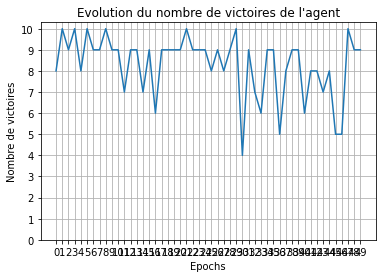

In [89]:
plt.plot(np.arange(EPOCHS), nb_wins_history)
plt.title("Evolution du nombre de victoires de l'agent")
plt.xticks(np.arange(EPOCHS))
plt.yticks([i for i in range(nb_games_test+1)])
plt.xlabel("Epochs")
plt.ylabel("Nombre de victoires")
plt.grid()
plt.show()

# 7) Test de partie

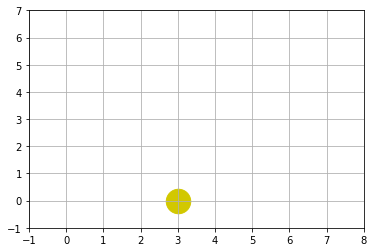

Choisissez une colonne : 5


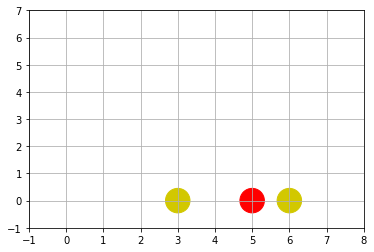

Choisissez une colonne : 5


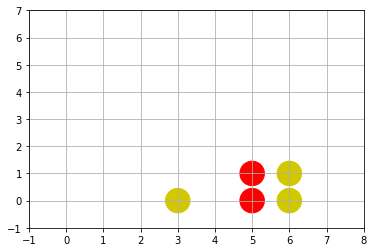

Choisissez une colonne : 5


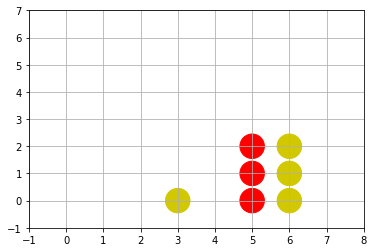

Choisissez une colonne : 5


In [92]:
game = Game()
game_finished = False
while not game_finished:
    observation = game.get_observation()
    illegal_actions = [i for i in range(nb_actions) if not game.is_legal(i)]
    action = agent.act(observation, illegal_actions, training=True)
    game.set_token(action)
    game.render()

    if game.won(0):
        game_finished = True
    
    elif game.is_draw():
        game_finished = True
    
    else:
        player_action = int(input(("Choisissez une colonne : ")))
        game.set_token(player_action)
        if game.won(1) or game.is_draw():
            game_finished = True



